# TCC - Avaliando Estratégias na Bolsa de Valores

## Inicialização do programa

### Importar bibliotecas

In [1]:
#Importar bibliotecas
import pandas as pd
import seaborn as sb
import plotly.graph_objects as go

### Parametrização da execução

In [33]:
#Parametros gerais para análise

#Ações a serem avaliadas
acoes_interesse = ['CMIG4']

#Períodos a serem avaliados
#year_date =['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
anos_analise =['2019', '2020']

##Path de Input
path_input_principal = 'C:\\Users\\rafael.melero\\Desktop\\Projetos\\MBA_PUC\\001 - Coleta de dados\\'

# Configurando Gráficos
sb.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

## Carga dos dados

### LOAD histórico da B3

In [34]:
#Leitura do arquivo da B3
def ler_arquivos_b3 (path, anos):
    
    _file = f'{path}B3//COTAHIST_A{anos}.TXT'
    
    colsspecs = [(2,10),
                 (10,12),
                 (12,24),
                 #(27,39),
                 (56,69),
                 (69,82),
                 (82,95),
                 (108,121)#,
                 #(152,170),
                 #(170,188)    
                ]

    colsnames = ["DATA_PREGAO",
                "COD_BDI",
                 "CODIGO_NEGOCIACAO",
                 #"NOME_EMPRESA",
                 "PRECO_ABERTURA",
                 "PRECO_MAXIMO",
                 "PRECO_MINIMO",
                 "PRECO_FECHAMENTO"#,
                 #"QUATIDADE_NEGOCIOS",
                 #"VOLUME_NEGOCIOS"
                ]

    df = pd.read_fwf(filepath_or_buffer=_file, colspecs=colsspecs, names=colsnames, skiprows = 1)
    
    return df

#Ajuste de colunas do Dataframe
def etl_b3_files (df):
    
    #Filtrar ações - Lote Padrão
    df = df[df['COD_BDI'] == 2]
    df = df.drop(['COD_BDI'], 1)    
    
    #Ajuste de colunas
    df['DATA_PREGAO'] = pd.to_datetime(df['DATA_PREGAO'])    
    df['PRECO_ABERTURA'] = (df['PRECO_ABERTURA']/100).astype(float)
    df['PRECO_MAXIMO'] = (df['PRECO_MAXIMO']/100).astype(float)
    df['PRECO_MINIMO'] = (df['PRECO_MINIMO']/100).astype(float)
    df['PRECO_FECHAMENTO'] = (df['PRECO_FECHAMENTO']/100).astype(float)    
    
    return df

In [35]:
#Ler e juntar os arquivos de histórico da B3 em um único Dataframe
def ler_historico_b3(path, anos_analise, acoes_interesse):
    for i, y in enumerate(anos_analise):
        
        df = ler_arquivos_b3(path, y)
        
        #Filtrar ações de interesse
        df = df[df['CODIGO_NEGOCIACAO'].isin(acoes_interesse)]

        df = etl_b3_files(df)
        
        if i ==0:
            df_final = df
        else:
            df_final = pd.concat([df_final, df])           
    
    return df_final

### LOAD StatusInvest: Dividendos

In [36]:
def ler_dividendos_statusinvest(path, anos_analise, acoes_interesse):
    
    _file = f'{path}StatusInvest\\Dividendos.xlsx'
    
    df_dividendos = pd.read_excel(_file)
    
    #Removendo colunas
    df_dividendos.drop('TIPO', axis='columns', inplace=True)
    df_dividendos.drop('PAGAMENTO', axis='columns', inplace=True)
    
    #Renomeando colunas
    df_dividendos.rename(columns = {'CODNEG':'CODIGO_NEGOCIACAO', 'DATA COM':'DATA_PREGAO', 'VALOR':'DIVIDENDO'}, inplace = True)
    
    return df_dividendos    

### Executando o LOAD dos arquivos

In [37]:
#Carregar os dados
df_historico = ler_historico_b3(path_input_principal, anos_analise, acoes_interesse)
df_dividendos = ler_dividendos_statusinvest(path_input_principal, anos_analise, acoes_interesse)

#Indexando base
df_historico.set_index(['DATA_PREGAO', 'CODIGO_NEGOCIACAO'], inplace= True)
df_dividendos.set_index(['DATA_PREGAO', 'CODIGO_NEGOCIACAO'], inplace= True)

## Verificação de Datasets

### Dataframe Histórico B3

In [41]:
#Descrever dataset
#df_historico.describe()
df_historico

,,PRECO_ABERTURA,PRECO_MAXIMO,PRECO_MINIMO,PRECO_FECHAMENTO
DATA_PREGAO,CODIGO_NEGOCIACAO,,,,
2019-01-02,CMIG4,13.85,14.60,13.80,14.30
2019-01-03,CMIG4,14.08,14.27,13.77,14.00
2019-01-04,CMIG4,14.14,14.25,13.77,13.86
2019-01-07,CMIG4,13.86,14.05,13.17,13.45
2019-01-08,CMIG4,13.45,13.59,13.02,13.38
...,...,...,...,...,...
2020-12-22,CMIG4,13.58,13.87,13.55,13.85
2020-12-23,CMIG4,13.90,14.28,13.88,14.18
2020-12-28,CMIG4,14.32,14.64,14.30,14.52


In [19]:
#Verificando duplicidades no index
df_historico.index.has_duplicates

False

In [20]:
#Verificando valores Nulos e inválidos
print(df_historico.isna().sum())

PRECO_ABERTURA      0
PRECO_MAXIMO        0
PRECO_MINIMO        0
PRECO_FECHAMENTO    0
dtype: int64


<AxesSubplot:>

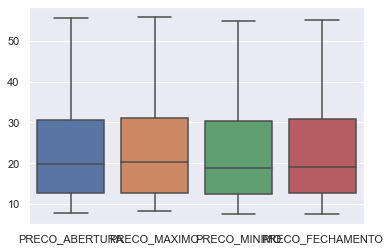

In [21]:
#Verificando Outliers - Identificamos que apenas na TAEE11 temos valores que extrapolam 
sb.boxplot(data = df_historico.reset_index(), fliersize=5, )

    DATA_PREGAO CODIGO_NEGOCIACAO  PRECO_ABERTURA  PRECO_MAXIMO  PRECO_MINIMO  \
436  2020-10-01             CMIG4           10.10         10.29          9.96   
437  2020-10-02             CMIG4           10.17         10.44         10.09   
438  2020-10-05             CMIG4           10.16         10.58         10.02   
439  2020-10-06             CMIG4           10.56         10.64         10.37   
440  2020-10-07             CMIG4           10.46         10.53         10.26   
..          ...               ...             ...           ...           ...   
492  2020-12-22             CMIG4           13.58         13.87         13.55   
493  2020-12-23             CMIG4           13.90         14.28         13.88   
494  2020-12-28             CMIG4           14.32         14.64         14.30   
495  2020-12-29             CMIG4           14.62         14.67         14.34   
496  2020-12-30             CMIG4           14.49         14.66         14.35   

     PRECO_FECHAMENTO  
436

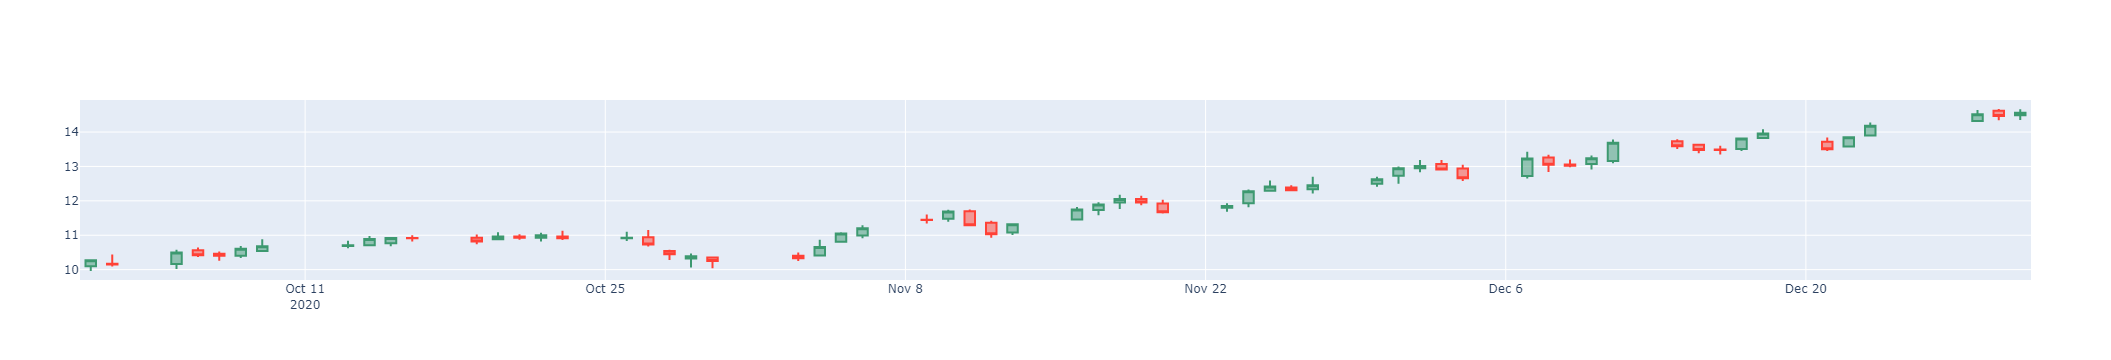

In [39]:
#Analisando Outliers TAEE11
df_teste = df_historico.query("CODIGO_NEGOCIACAO == 'CMIG4'")
df_teste = df_teste.reset_index()

df_teste = df_teste.query("DATA_PREGAO >= '2020-10-01'")
print(df_teste)

fig = go.Figure(data=[go.Candlestick(x=df_teste['DATA_PREGAO'],
                open=df_teste['PRECO_ABERTURA'], high=df_teste['PRECO_MAXIMO'],
                low=df_teste['PRECO_MINIMO'], close=df_teste['PRECO_FECHAMENTO'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()



### Dataframe Statusinvest Dividendos

In [23]:
#Descrever dataset
df_dividendos.describe()

,DIVIDENDO
count,282.000000
mean,0.251447
std,0.283556
min,0.001333
25%,0.067711
50%,0.168290
75%,0.318664
max,1.631192


In [24]:
#Verificando duplicidades no index
df_dividendos.index.has_duplicates

True

In [25]:
#Exibindo as duplicidades
df_dividendos.groupby(level=1).filter(lambda x: len(x) > 2)

DIVIDENDO
DATA_PREGAO CODIGO_NEGOCIACAO           
2021-05-18  TAEE11              0.188691
            TAEE11              1.165672
2021-05-04  TAEE11              1.631192
2020-12-15  TAEE11              0.157382
2020-11-16  TAEE11              1.192376
...                                  ...
2011-04-29  CMIG4               0.876728
            CMIG4               0.876728
2010-12-16  CMIG4               1.319409
2010-04-29  CMIG4               0.750430
            CMIG4               0.750430

[282 rows x 1 columns]

In [26]:
#Resolvendo as duplicidades
df_dividendos = df_dividendos.groupby(by=['DATA_PREGAO', 'CODIGO_NEGOCIACAO']).sum()
df_dividendos.index.has_duplicates

False

In [27]:
#Descrever dataset
df_dividendos.describe()

,DIVIDENDO
count,224.000000
mean,0.316554
std,0.431195
min,0.005950
25%,0.069904
50%,0.181439
75%,0.409015
max,3.870266


<AxesSubplot:xlabel='CODIGO_NEGOCIACAO', ylabel='DIVIDENDO'>

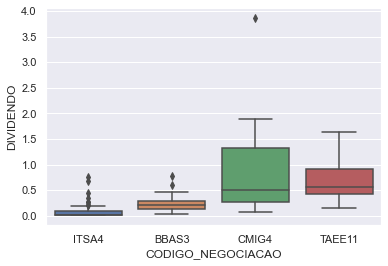

In [28]:
# Verificando outliers, porém esta informação já é esperada a pagamentos esporádicos
sb.boxplot(x = 'CODIGO_NEGOCIACAO', y='DIVIDENDO', data = df_dividendos.reset_index(), fliersize=5)

In [29]:
df_dividendos.reset_index()

,DATA_PREGAO,CODIGO_NEGOCIACAO,DIVIDENDO
0,2010-01-01,ITSA4,0.035000
1,2010-02-25,BBAS3,0.466812
2,2010-03-02,ITSA4,0.181457
3,2010-03-24,BBAS3,0.201718
4,2010-04-29,CMIG4,1.500860
...,...,...,...
219,2021-05-31,ITSA4,0.020000
220,2021-06-11,BBAS3,0.168519
221,2021-08-31,ITSA4,0.020000
222,2021-11-30,ITSA4,0.020000


### Fazendo o merge dos dados

In [30]:
#Fazendo o join dos datasets
df_dados = df_historico.join(df_dividendos, how='left')

# ***********************************************************************************

In [31]:
df_dividendos.describe()

,DIVIDENDO
count,224.000000
mean,0.316554
std,0.431195
min,0.005950
25%,0.069904
50%,0.181439
75%,0.409015
max,3.870266


In [32]:
df_dados.describe()

,PRECO_ABERTURA,PRECO_MAXIMO,PRECO_MINIMO,PRECO_FECHAMENTO,DIVIDENDO
count,1988.000000,1988.000000,1988.000000,1988.000000,43.000000
mean,23.732334,24.040900,23.381393,23.703808,0.286240
std,13.451120,13.611395,13.268047,13.432458,0.280646
min,7.790000,8.270000,7.440000,7.530000,0.005950
25%,12.645000,12.810000,12.477500,12.640000,0.090346
50%,19.910000,20.240000,18.795000,19.050000,0.181421
75%,30.702500,31.140000,30.272500,30.790000,0.440534
max,55.600000,55.910000,54.820000,55.180000,1.361942


In [22]:
#Verificando ddados nulos
df_dados.isnull().sum()

PRECO_ABERTURA         0
PRECO_MAXIMO           0
PRECO_MINIMO           0
PRECO_FECHAMENTO       0
DIVIDENDO           1945
dtype: int64

In [23]:
df_dados['DIVIDENDO'] = df_dados['DIVIDENDO'].fillna(0)
df_dados.isnull().sum()

PRECO_ABERTURA      0
PRECO_MAXIMO        0
PRECO_MINIMO        0
PRECO_FECHAMENTO    0
DIVIDENDO           0
dtype: int64

In [24]:
df_dados['DIVIDENDO_ACUMULADO'] = df_dados['DIVIDENDO'].cumsum(axis='index')

In [25]:
# Verificando que ao realizar o merge cada ação pode ter mais de um pagamento por dia
df_dados.query("DATA_PREGAO == '2020-12-30'")

PRECO_ABERTURA  PRECO_MAXIMO  PRECO_MINIMO  \
DATA_PREGAO CODIGO_NEGOCIACAO                                               
2020-12-30  BBAS3                       39.28         39.35         38.66   
            CMIG4                       14.49         14.66         14.35   
            ITSA4                       11.89         11.94         11.70   
            TAEE11                      33.62         33.66         33.21   

                               PRECO_FECHAMENTO  DIVIDENDO  \
DATA_PREGAO CODIGO_NEGOCIACAO                                
2020-12-30  BBAS3                         38.80   0.000000   
            CMIG4                         14.56   0.285533   
            ITSA4                         11.73   0.000000   
            TAEE11                        33.33   0.000000   

                               DIVIDENDO_ACUMULADO  
DATA_PREGAO CODIGO_NEGOCIACAO                       
2020-12-30  BBAS3                        12.022767  
            CMIG4                        12.308301  
            ITSA4                        12.308301  
            TAEE11                       12.308301

In [26]:
df_dividendos.query("DATA_PREGAO == '2020-12-30'")

,,DIVIDENDO
DATA_PREGAO,CODIGO_NEGOCIACAO,
2020-12-30,CMIG4,0.285533


In [27]:
#Realizando o join novamente agora com as informações sem duplicidade
df_dados = df_historico.join(df_dividendos, how='left')
# Verificando que ao realizar o merge cada ação pode ter mais de um pagamento por dia
df_dados.query("DATA_PREGAO == '2020-12-30'")

PRECO_ABERTURA  PRECO_MAXIMO  PRECO_MINIMO  \
DATA_PREGAO CODIGO_NEGOCIACAO                                               
2020-12-30  BBAS3                       39.28         39.35         38.66   
            CMIG4                       14.49         14.66         14.35   
            ITSA4                       11.89         11.94         11.70   
            TAEE11                      33.62         33.66         33.21   

                               PRECO_FECHAMENTO  DIVIDENDO  
DATA_PREGAO CODIGO_NEGOCIACAO                               
2020-12-30  BBAS3                         38.80        NaN  
            CMIG4                         14.56   0.285533  
            ITSA4                         11.73        NaN  
            TAEE11                        33.33        NaN